In [4]:

import ccxt
from datetime import datetime as dt,timedelta
from hurst import compute_Hc
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt
import warnings
import plotly.graph_objects as go

warnings.filterwarnings('ignore')

# from pandas.tseries.offsets import BDay

# !pip install -U vectorbt
ex = ccxt.ftx({'enableRateLimit':True})


In [5]:
# Get Data 

def get_data(symbols:str  , **kwarg ):

    data= pd.DataFrame(ex.fetch_ohlcv(symbols,**kwarg ),columns=['date','open','high','low','close','volume'])
#         data.drop(columns='volume',inplace=True)
    data['date']=data['date'].apply(ex.iso8601)
    data['date']=pd.to_datetime(data['date'])
#   df['date']=df['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
#   df['date']=pd.to_datetime(df['date'])
    data.set_index('date',inplace=True)

    return data

def cal_consecutive(df:pd.DataFrame):

    df['win']= np.sign(df) # assign sign on log
    blocks = df['win'].ne(df['win'].shift()).cumsum() 
    df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
    return df['consecutive_WL'] 

        
def count_time(condition_cols = pd.DataFrame): 
    # Count True conditiong

    count_  = np.full(condition_cols.shape[0],0)
    for i in range(condition_cols.shape[0]): # for loop in range series
        
        if condition_cols.iloc[i] ==True:
            count_[i] =  1 + count_[i-1]
        else:
            count_[i] = 0
    return count_  # np.array



def get_ticker(symbol):
    i= 0
    while i< 5:
        try:
            res =ex.fetch_ticker(symbol)
            return res
        except Exception as e:
            if i >5:
                print(f'[{get_time()}]MAX RETRY {i} , {str(e)} Cannot GET {get_ticker.__name__}')
                logger.debug(f'Cant get get_ticker Function, MAX RETRY {i} !!')
                
                return  None
            else:
                print(str(e) , get_ticker.__name__, f' RETRY {i}')
                logger.debug(f'Cant get get_ticker Function, Retry round {i}')
                time.sleep(5)
                i+=1    


def get_price_digit(symbol): 
    try:
        res =get_ticker(symbol)
        price_step = (res['info']['priceIncrement'])
        count_digit = len(price_step.split('.')[1])

        return count_digit
    except Exception as e :
        print(str(e))
        
def sharpe_ratio(rets, rf=0.01, n=252, opt=""):
    if opt == "sim_rets":
        rets = (np.exp(rets)-1)
        
    rp = rets.mean()*n
    sigma = rets.std()*np.sqrt(n)
    return (rp-rf)/ sigma
        
        
def cagr(rets, n =252):
    
    starting = 1
    final = rets.cumsum().apply(np.exp)[-1]
    n_year = len(rets)/n
    cagr = (final/starting)**(1/n_year)-1
    return cagr

def volatility(rets, n=252):
    
    vol = rets.std()*np.sqrt(n)
    return vol

In [6]:
stg_side= 'long'
symbols= 'ZIL-PERP'
SL=False
print('Price DIGIT' , get_price_digit(symbols))

pd.set_option('display.max_columns', 30)
pd.set_option('display.float_format', '{:.5f}'.format)


Price DIGIT 5


In [24]:
con_1= (df['high'] / df['low'].shift(3) -1)>0.003
con_2 = df['high'] > df['low'].shift(3)
con_3 = df['close'] >df['ema_long']


In [22]:



# pd.set_option('display.precision', 2)

df = get_data(symbols,**{'timeframe':'5m'})
df['ret'] = np.log(df['close']/df['close'].shift(1))

df['cum_rets'] = df['ret'].cumsum().apply(np.exp)
df['cum_max'] = df['cum_rets'].cummax()
df['drawndown'] = (df['cum_rets']/df['cum_max'])-1
df['volume_ma'] = (df['volume'].rolling(20).mean()).round(get_price_digit(symbols))
df['volume'] =np.sign(df['ret']) * df['volume']


# Convert Volumes Columns to 1m 

# df['volume_million'] =df['volume'].astype(int) /1000000
# df.drop(columns='volume',inplace=True)
# df['volume_ma'] = (df['volume_million'].rolling(20).mean()).round(get_price_digit(symbols))
# Multiply Sign ret to volumne
# df['volume_million'] =np.sign(df['ret']) * df['volume_million']
df['con_wl'] =cal_consecutive(df['ret'])

atr= df.ta.atr(20)
# Volatility Columns 
df['vol_exp'] = (df.ta.stdev(length=20).ewm(alpha=0.96).mean() /df.close)
# df['vol_exp_'] = ((df.close/df.close.shift(1)).rolling(200).std()*252**.5).ewm(alpha=0.96)
df['ema_long']= df.ta.ema(200)


# df['vol_20'] = df['close'].rolling(20).std().ewm(alpha=0.96).mean() /df.close#.plot()
df['atr_pct']  =(atr /df.close)

if SL:
    if stg_side== 'long':
        df['sl_vol'] =df.close - (df.close * df.vol_exp)
        # df['sl_vol_20'] =df.close - (df.close * df.vol_20)
        df['sl_atr_pct'] =df.close - (df.close * df.atr_pct)
    else:
        print(stg_side)
        df['sl_vol'] = ( (df.close * df.vol_exp)*2) + df.close
        # df['sl_vol_20'] = (df.close * df.vol_20)+ df.close
        df['sl_atr_pct'] = ((df.close * df.atr_pct)*2) + df.close
    
    
df.tail(30)


,open,high,low,close,volume,ret,cum_rets,cum_max,drawndown,volume_ma,con_wl,vol_exp,ema_long,atr_pct
date,,,,,,,,,,,,,,
2022-04-17 08:30:00+00:00,0.11381,0.11400,0.11364,0.11377,-73130.18310,-0.00035,1.03127,1.14675,-0.10070,94396.81248,-2.00000,0.00324,0.11237,0.00363
2022-04-17 08:35:00+00:00,0.11377,0.11382,0.11359,0.11368,-53778.73310,-0.00079,1.03046,1.14675,-0.10141,95268.55349,-3.00000,0.00324,0.11238,0.00355
2022-04-17 08:40:00+00:00,0.11368,0.11378,0.11347,0.11354,-60024.47850,-0.00123,1.02919,1.14675,-0.10252,90961.80710,-4.00000,0.00326,0.11239,0.00352
2022-04-17 08:45:00+00:00,0.11354,0.11374,0.11333,0.11347,-83501.50240,-0.00062,1.02855,1.14675,-0.10307,88225.30042,-5.00000,0.00319,0.11240,0.00352
2022-04-17 08:50:00+00:00,0.11346,0.11365,0.11339,0.11362,39098.70010,0.00132,1.02991,1.14675,-0.10189,86128.35916,1.00000,0.00306,0.11242,0.00346
2022-04-17 08:55:00+00:00,0.11362,0.11379,0.11356,0.11358,-30408.96340,-0.00035,1.02955,1.14675,-0.10221,82792.08615,-1.00000,0.00299,0.11243,0.00339
2022-04-17 09:00:00+00:00,0.11358,0.11365,0.11310,0.11329,-77802.46640,-0.00256,1.02692,1.14675,-0.10450,83191.31147,-2.00000,0.00305,0.11244,0.00347
2022-04-17 09:05:00+00:00,0.11329,0.11360,0.11323,0.11358,63908.98030,0.00256,1.02955,1.14675,-0.10221,84146.39638,1.00000,0.00303,0.11245,0.00345
2022-04-17 09:10:00+00:00,0.11358,0.11416,0.11356,0.11397,100054.41880,0.00343,1.03309,1.14675,-0.09912,86860.18896,2.00000,0.00306,0.11246,0.00353


In [20]:
# Indicator Columns
df['shift_20']  =df.close.shift(20)
df['roc_20']  =ta.roc(df['close'],length=20)
df['momentum']= df['close'] /df['close'].shift(20) -1
df['pct_mm'] = np.log(df['momentum']/ df['momentum'].shift(1))
df['pct_vol']   = np.log(df['vol_exp']/ df['vol_exp'].shift(1))
df['ema_short']= df.ta.ema(50)
df['ema_long']= df.ta.ema(200)
df['diff_ema']  = (df['ema_short'] - df['ema_long'])
df['diff_close_ema']  = ( df['close'] - df['ema_long'])


df['hurst']= 0.0
for i in range(120,len(df)):
    df.iloc[i,df.columns.get_loc('hurst')]=compute_Hc(df['close'].iloc[i-120:i-1], kind='price')[0]
df['pct_hurst'] = np.log(df['hurst']/ df['hurst'].shift(1))

In [64]:

# 
#  Calculate From last 252 Bars  , Functions Work For Daily Time Frame
print(f"cagr: {cagr(df['ret'])*100:.2f} %")
print(f'Yearly volatility {volatility(df["ret"])*100:.3}')
print(f'Sharpe ratio: {sharpe_ratio(df["ret"]):.4}')
print(f'Sharpe ratio simple return: {sharpe_ratio(df["ret"], opt= "sim_rets"):.4}')

cagr: -6.21 %
Yearly volatility 10.5
Sharpe ratio: -0.7034
Sharpe ratio simple return: -0.6509


In [90]:
df.tail(20)


,open,high,low,close,volume,ret,cum_rets,cum_max,drawndown,volume_ma,con_wl,vol_exp,atr_pct,shift_20,roc_20,momentum,pct_mm,pct_vol,ema_short,ema_long,diff_ema,diff_close_ema,hurst,pct_hurst,mae,mfe,pnl,volatile
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-07 11:20:00+00:00,0.12527,0.12603,0.12521,0.12572,367259.12530,0.00359,0.68148,1.11389,-0.38819,222218.35084,1.00000,0.00359,0.00700,0.12432,1.12613,0.01126,0.52377,0.09596,0.12488,0.12652,-0.00164,-0.00080,0.49880,-0.01527,-0.00048,0.00607,0.00359,0.00655
2022-04-07 11:25:00+00:00,0.12572,0.12626,0.12572,0.12584,142084.24250,0.00095,0.68213,1.11389,-0.38761,220959.39406,2.00000,0.00389,0.00686,0.12426,1.27153,0.01272,0.12144,0.07989,0.12492,0.12652,-0.00160,-0.00068,0.53141,0.06333,0.00000,0.00430,0.00095,0.00430
2022-04-07 11:30:00+00:00,0.12585,0.12694,0.12557,0.12693,371448.91620,0.00862,0.68804,1.11389,-0.38231,235072.90615,3.00000,0.00495,0.00700,0.12405,2.32164,0.02322,0.60206,0.23934,0.12500,0.12652,-0.00152,0.00041,0.55004,0.03447,-0.00215,0.00874,0.00866,0.01089
2022-04-07 11:35:00+00:00,0.12693,0.12745,0.12663,0.12693,0.00000,0.00000,0.68804,1.11389,-0.38231,243948.97975,0.00000,0.00581,0.00697,0.12437,2.05837,0.02058,-0.12036,0.16007,0.12508,0.12652,-0.00145,0.00041,0.56148,0.02058,-0.00236,0.00410,0.00000,0.00646
2022-04-07 11:40:00+00:00,0.12693,0.12766,0.12668,0.12760,314448.83080,0.00526,0.69167,1.11389,-0.37905,236469.43580,1.00000,0.00699,0.00697,0.12447,2.51466,0.02515,0.20022,0.18558,0.12517,0.12654,-0.00136,0.00106,0.54630,-0.02742,-0.00197,0.00575,0.00528,0.00772
2022-04-07 11:45:00+00:00,0.12760,0.12763,0.12663,0.12680,-350428.20130,-0.00629,0.68734,1.11389,-0.38294,243946.57921,-1.00000,0.00749,0.00706,0.12495,1.48059,0.01481,-0.52970,0.06905,0.12524,0.12654,-0.00130,0.00026,0.51144,-0.06593,-0.00760,0.00024,-0.00627,-0.00737
2022-04-07 11:50:00+00:00,0.12679,0.12695,0.12624,0.12675,-206067.96420,-0.00039,0.68707,1.11389,-0.38318,247086.42051,-2.00000,0.00775,0.00699,0.12471,1.63580,0.01636,0.09969,0.03371,0.12530,0.12654,-0.00124,0.00021,0.48560,-0.05185,-0.00442,0.00118,-0.00039,-0.00323
2022-04-07 11:55:00+00:00,0.12675,0.12725,0.12635,0.12708,189812.01590,0.00260,0.68886,1.11389,-0.38158,249717.98646,1.00000,0.00794,0.00698,0.12443,2.12971,0.02130,0.26386,0.02469,0.12537,0.12655,-0.00118,0.00053,0.48490,-0.00144,-0.00316,0.00394,0.00260,0.00710
2022-04-07 12:00:00+00:00,0.12708,0.12753,0.12676,0.12742,227378.32380,0.00267,0.69070,1.11389,-0.37992,254992.97094,2.00000,0.00838,0.00691,0.12497,1.96047,0.01960,-0.08280,0.05447,0.12545,0.12655,-0.00111,0.00087,0.47938,-0.01145,-0.00252,0.00354,0.00268,0.00606


In [85]:
# # Mae ,Mfe Bar to Bar
# df['mae'] =(df['low'] - df['close'].shift(1) ) /df['close'].shift(1)  
# df['mfe'] =(df['high'] - df['close'].shift(1) ) /df['close'].shift(1)  
# df['pnl'] = (df['close'] -df['close'].shift(1) ) / df['close'].shift(1) 
# df['volatile'] = df['mfe'] +abs(df['mae']) *  (np.where(df['mfe'] >= abs(df['mae']) ,1,-1)) # real volatility 




In [89]:
max_ret = df.groupby('con_wl').max()['ret']
min_ret= df.groupby('con_wl').min()['ret']
avg_ret = df.groupby('con_wl').mean()['ret']
count_ret  = df.groupby('con_wl').count()['ret']

wl_data =pd.concat([max_ret,min_ret,avg_ret,count_ret],axis=1)
wl_data.columns = ['max_ret','min_ret','avg_ret','count_ret']
wl_data['pct_count_ret'] = wl_data['count_ret'] / len(df) *100
display(wl_data)
print('#'*100)
df.sort_values('ret',ascending=False).head(10).iloc[:,0:6]


,max_ret,min_ret,avg_ret,count_ret,pct_count_ret
con_wl,,,,,
-9.00000,-0.00820,-0.01294,-0.01057,2,0.13324
-8.00000,-0.00974,-0.03287,-0.02131,2,0.13324
-7.00000,-0.00725,-0.01131,-0.00911,4,0.26649
-6.00000,-0.00180,-0.00967,-0.00493,9,0.59960
-5.00000,-0.00007,-0.01486,-0.00416,20,1.33245
-4.00000,-0.00034,-0.03293,-0.00634,45,2.99800
-3.00000,-0.00007,-0.03212,-0.00525,95,6.32911
-2.00000,-0.00006,-0.03960,-0.00489,191,12.72485
-1.00000,-0.00007,-0.02312,-0.00474,388,25.84943


####################################################################################################


,open,high,low,close,volume,ret
date,,,,,,
2022-04-02 14:00:00+00:00,0.19800,0.20655,0.19692,0.20515,5359407.33500,0.03547
2022-04-06 01:00:00+00:00,0.12708,0.13112,0.12663,0.13080,1589390.49120,0.02885
2022-04-06 09:10:00+00:00,0.13314,0.13724,0.13311,0.13690,1935828.01020,0.02785
2022-04-06 14:05:00+00:00,0.12610,0.12934,0.12576,0.12928,966767.65260,0.02491
2022-04-03 00:05:00+00:00,0.16662,0.17519,0.16662,0.17059,3809627.11480,0.02355
2022-04-06 00:00:00+00:00,0.12439,0.12748,0.12409,0.12732,985075.09310,0.02328
2022-04-06 17:05:00+00:00,0.13451,0.13773,0.13395,0.13762,1149058.57720,0.02293
2022-04-02 13:45:00+00:00,0.18760,0.19251,0.18757,0.19191,1465531.64500,0.02271
2022-04-06 15:30:00+00:00,0.13073,0.13433,0.12882,0.13355,2266008.56980,0.02211


# All Plot To Anlysis Markets [ Pandas Backend Plotly ]

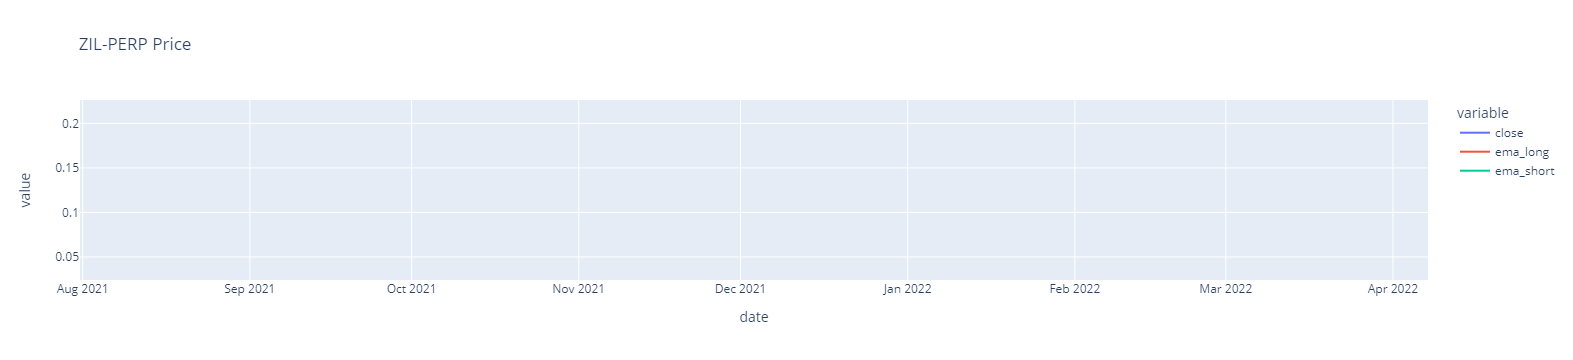

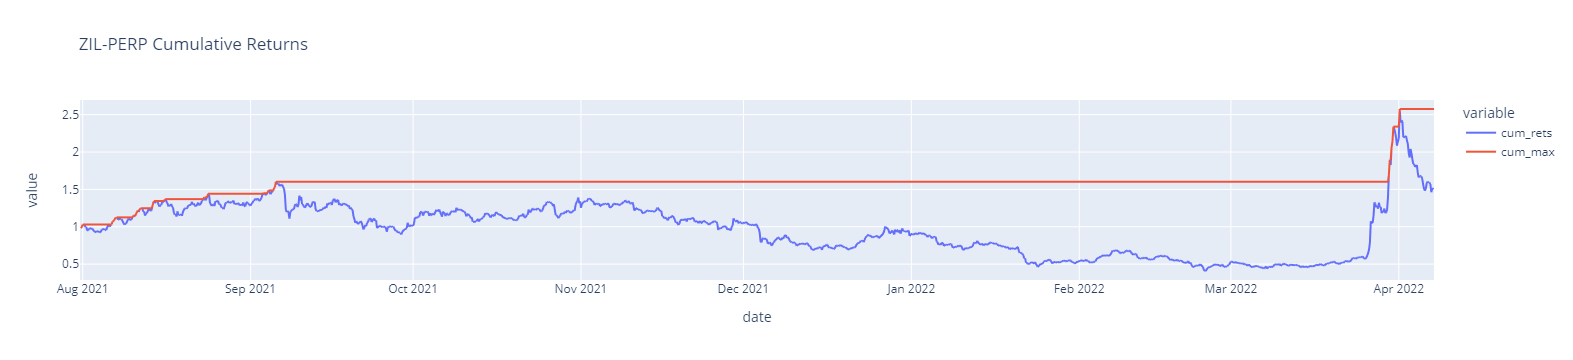

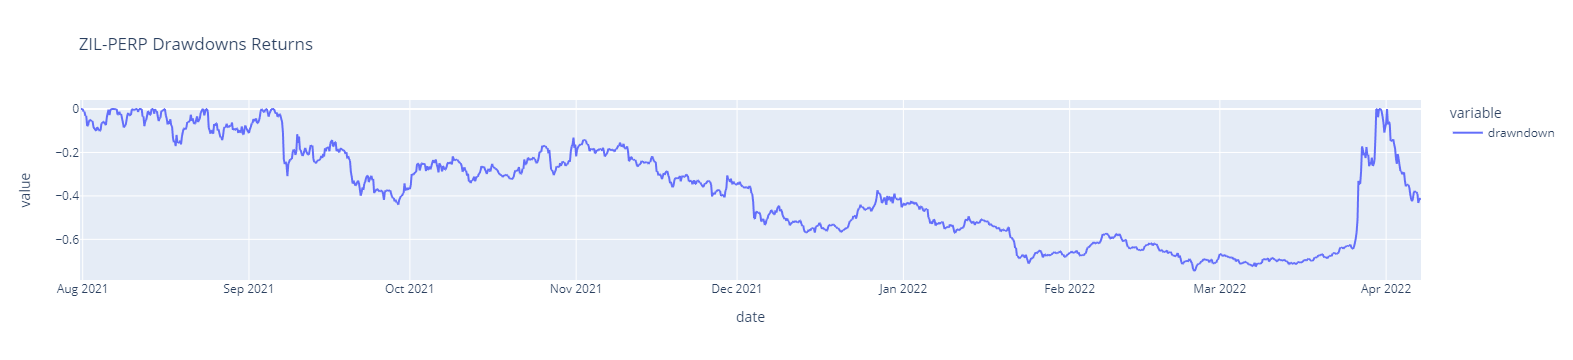

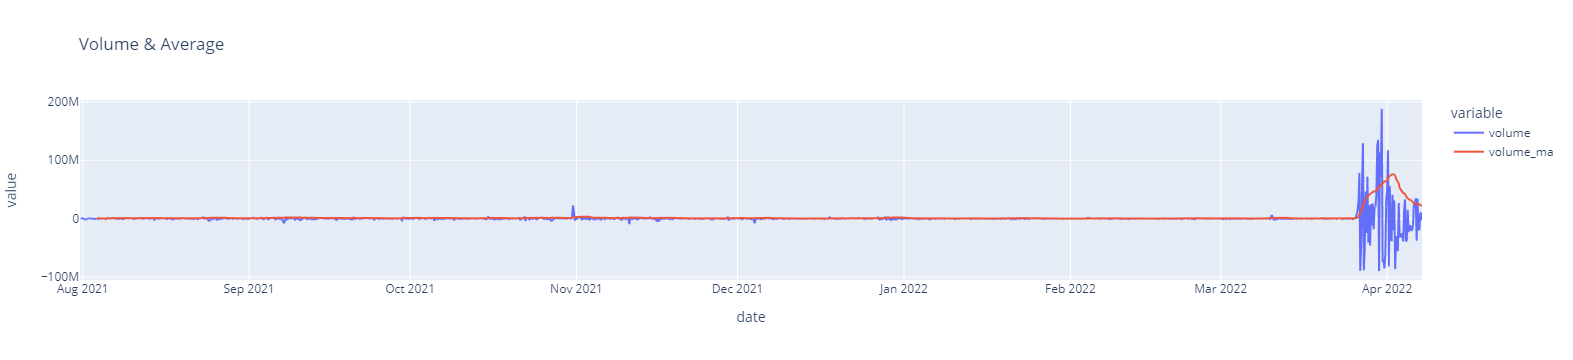

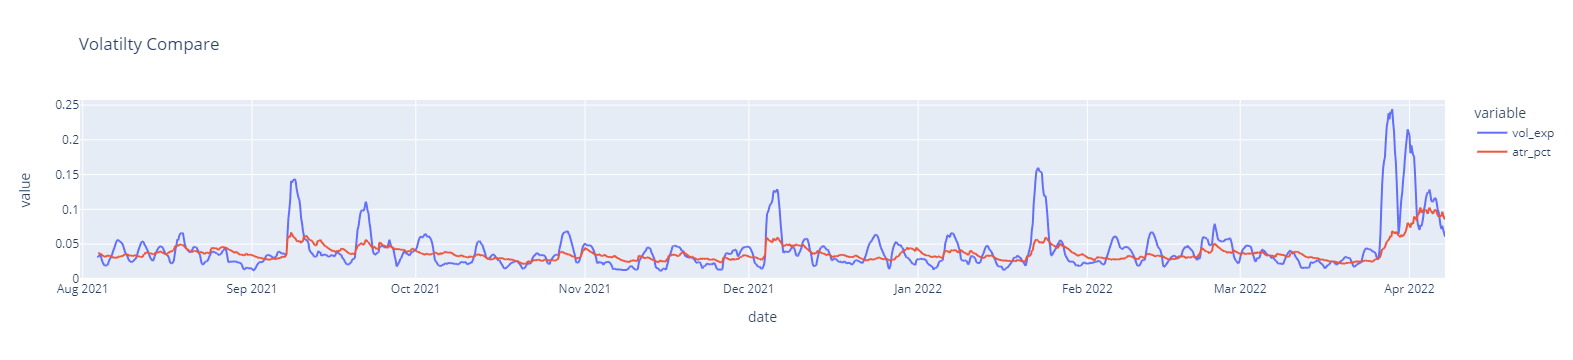

In [56]:
pd.options.plotting.backend = "plotly"
fig = go.Figure()
df[['close','ema_long','ema_short']].plot(title=f' {symbols} Price ').show()
df[['cum_rets','cum_max']].plot(title=f' {symbols} Cumulative Returns ').show() # drawndown
df[['drawndown']].plot(title=f' {symbols} Drawdowns Returns ').show()
df[['volume','volume_ma']].plot( title= f'Volume & Average').show()
df[['vol_exp','atr_pct']].plot( title= f'Volatilty Compare').show()


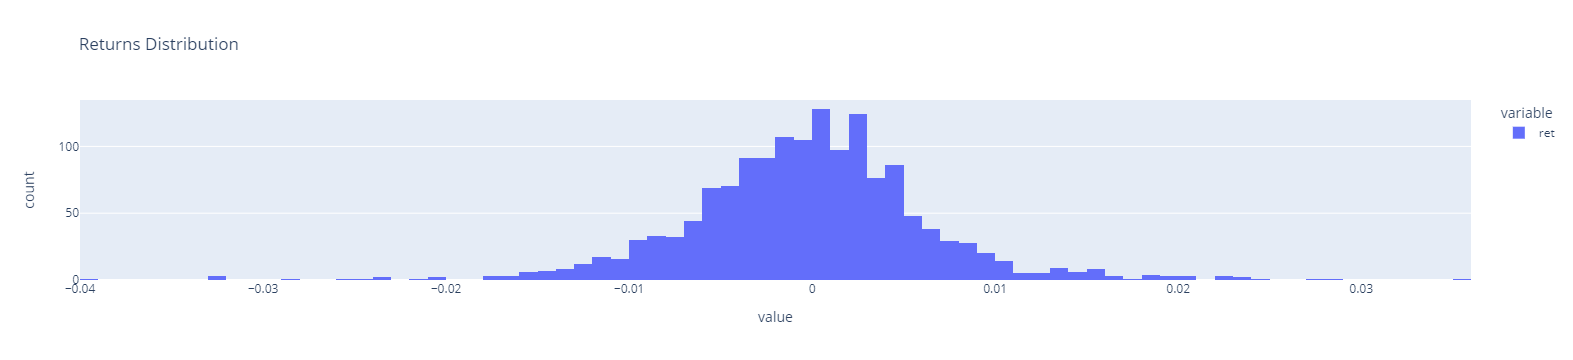

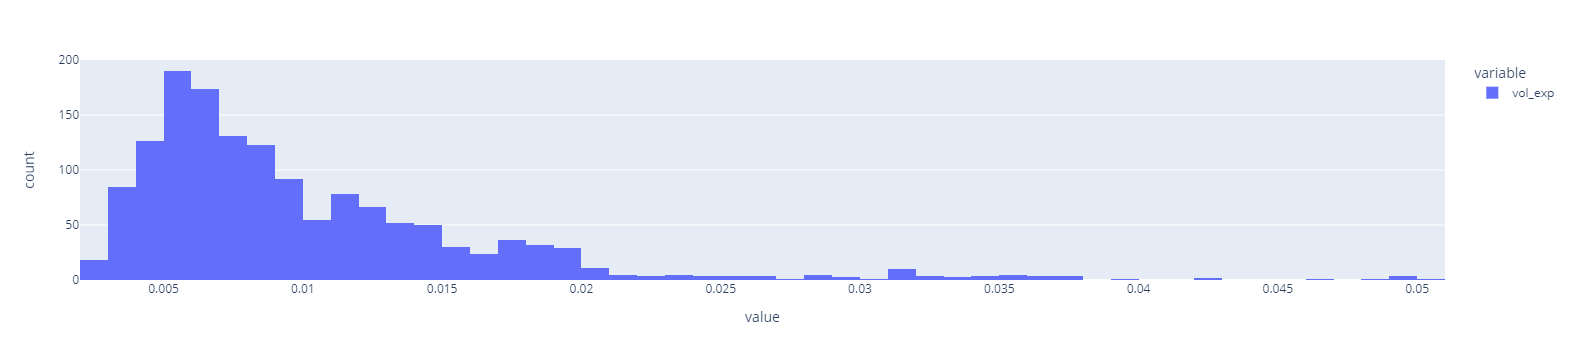

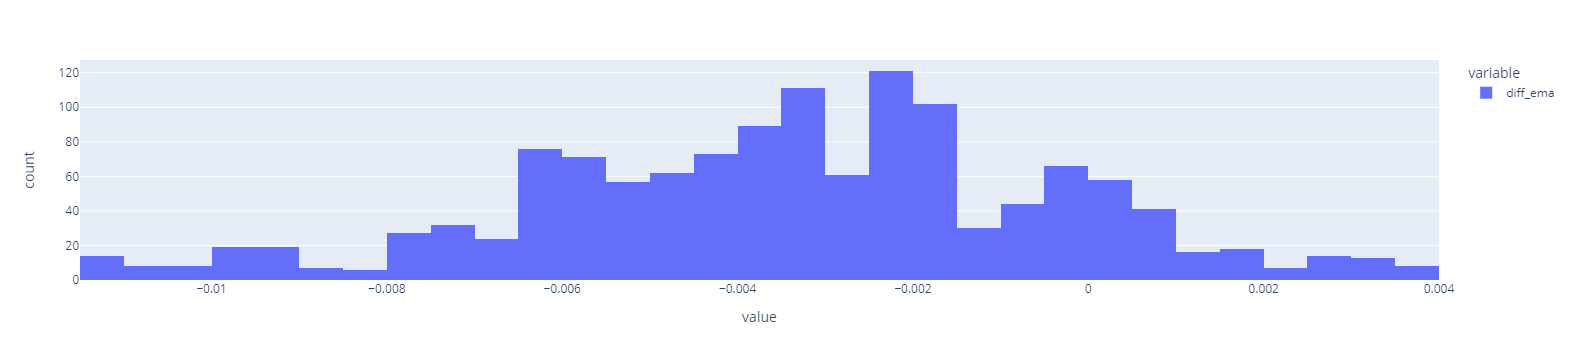

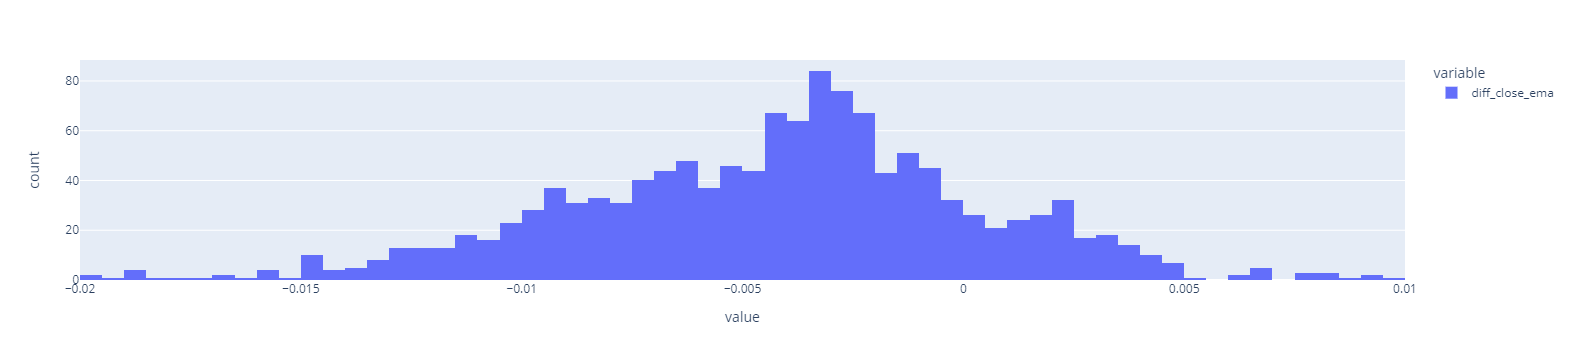

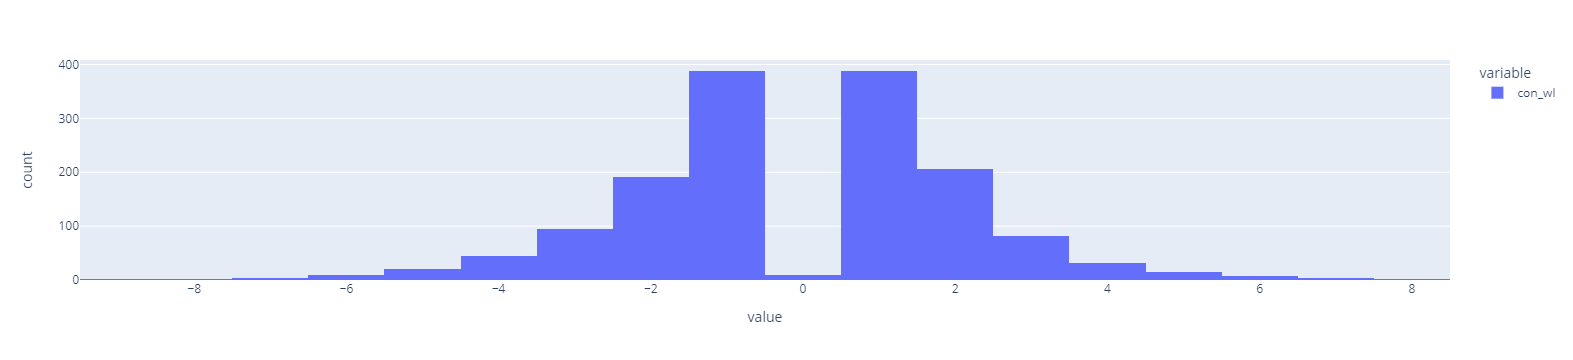

In [68]:
df[['ret']].plot.hist(title=' Returns Distribution').show()
df[['vol_exp']].plot.hist('Volatility Distribution').show()
df[['diff_ema']].plot.hist('Diff Between 2 EMA Distribution').show()
df[['diff_close_ema']].plot.hist('Diff Between  EMA and Close Distribution').show()
df[['con_wl']].plot.hist('Consecutive Returns Distribution').show()

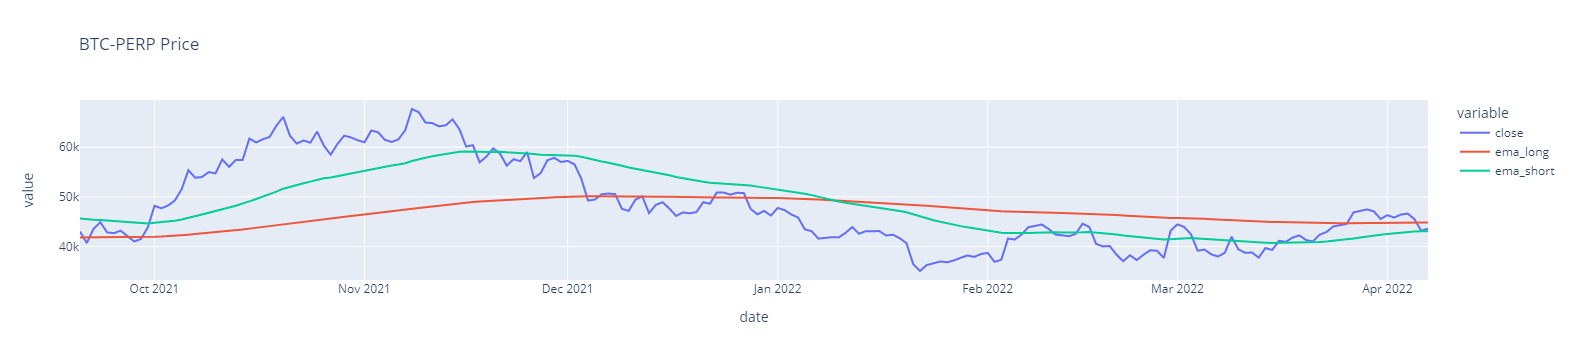

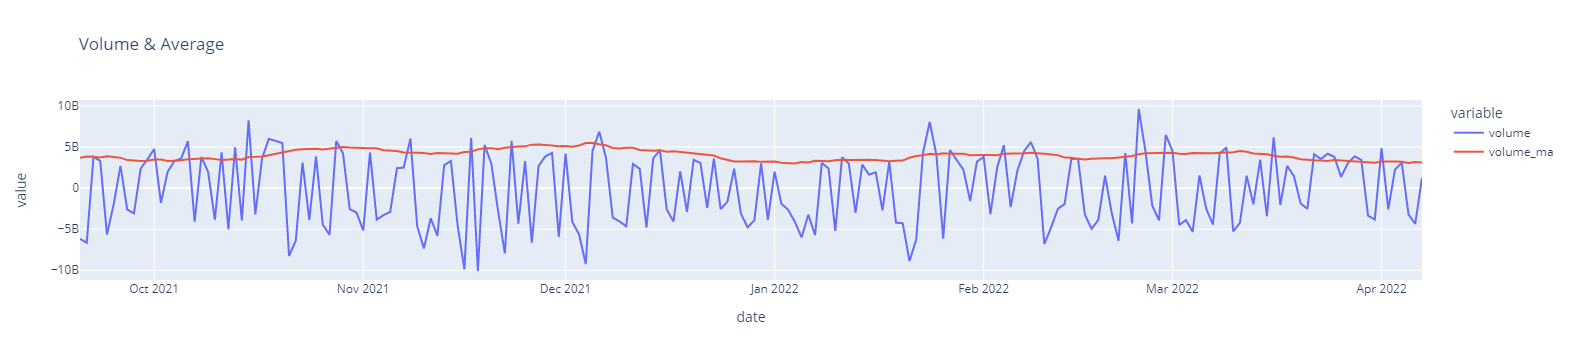

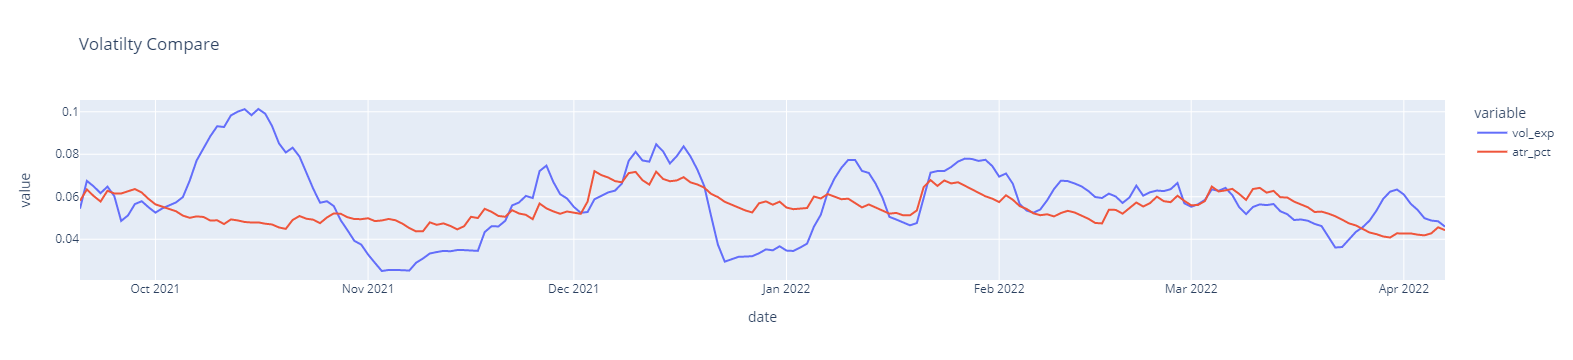

In [32]:
# Short View
last_bar = 200
df[-last_bar:][['close','ema_long','ema_short']].plot(title=f' {symbols} Price ').show()
df[-last_bar:][['volume','volume_ma']].plot( title= f'Volume & Average').show()
df[-last_bar:][['vol_exp','atr_pct']].plot( title= f'Volatilty Compare').show()



In [35]:
# df[-200:]['volume']